# Unsupervised Planogram Compliance

http://openaccess.thecvf.com/content_ECCV_2018/html/Archan_Ray_U-PC_Unsupervised_Planogram_ECCV_2018_paper.html
http://openaccess.thecvf.com/content_ECCV_2018/papers/Archan_Ray_U-PC_Unsupervised_Planogram_ECCV_2018_paper.pdf

In [1]:
# IMPORTING LIBRARIES

import os
import io
import sys
import numpy as np
from sklearn.cluster import KMeans
import cv2
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# KERNEL SIZE
k = 20
k_des = 100

# STRIDE
s = 20
s_des = 100

# NUMBER OF CLUSTERS 
n_clusters = 3
n_clusters_des = 6

## 1. Ready Input Rack Image
Input -> Crop -> Info Tuple (For Input Rack Image)

### 1.1 Input Image

Shape of rack image: (1060, 3805, 3)


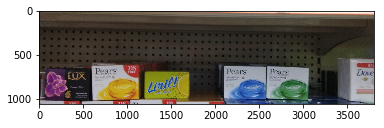

In [21]:
def read_rackImage(image_name):

    img=cv2.imread(image_name)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    X=np.array(img)
    print('Shape of rack image: ' + str(X.shape))
    
    return X, img
    
X, img = read_rackImage('set3_rack.jpeg')

### 1.2 Crop Image

Shape of cropped rack image 1: (954, 3805, 3)
Shape of cropped rack image 2: (940, 3800, 3)


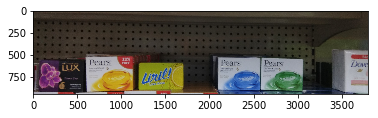

In [22]:
def crop_rackImage(X, img, k):

    h = np.shape(X)[0]
    
    # Step 1
    X = X[int(0.1*h):, :]
    print('Shape of cropped rack image 1: ' + str(np.shape(X)))
    
    h, w = np.shape(X[:,:,-1])
    
    # Step 2
    X = X[:h - h%k, :w - w%k]
    print('Shape of cropped rack image 2: ' + str(np.shape(X)))
    
    plt.imshow(X)
    
    return X, img

X, img = crop_rackImage(X, img, k)

### 1.3 Retrieve Image Information

In [23]:
def info_rackImage(X, img):
    
    h, w, channels = np.shape(X)
    info = (X, img, h, w, channels)
    
    return info

info = info_rackImage(X, img)

## 2. Get Features for Rack Image
Grid -> SURF Features 

### 2.1 Grid Formation

In [24]:
def sliding_window(info, k, s):

    X, h, w = info[0], info[2], info[3]
    X1np=[]
    
    for i in range(h//k):
        for j in range(w//k):
            
            window = X[i*k:i*k + k, j*k:j*k + k, :]
            X1np.append(np.asarray(window))
    
    X1np = np.asarray(X1np)
    
    # Flatten List of Sliding Windows
    X2np = X1np.reshape(X1np.shape[0], X1np.shape[1]*X1np.shape[2]*X1np.shape[3])
            
    return X1np, X2np

X1np ,X2np = sliding_window(info, k, s)
X1np_des, X2np_des = sliding_window(info, k_des, s_des)
print('Shape of list of sliding window instances (without feature descriptors): ' + str(X1np.shape) + ' '+str(X2np.shape))
print('Shape of list of sliding window instances (with feature descriptors): ' + str(X1np_des.shape) + ' '+str(X2np_des.shape))

Shape of list of sliding window instances (without feature descriptors): (8930, 20, 20, 3) (8930, 1200)
Shape of list of sliding window instances (with feature descriptors): (342, 100, 100, 3) (342, 30000)


### 2.2 SURF Features

In [25]:
X_des=[]

# Hyperparameter
n_features = 5

def surf_rackImage(X1np_des, n_features):
    
    for i in range(X1np_des.shape[0]):
        
        arr = np.zeros((n_features*32))
        surf = cv2.xfeatures2d.SURF_create()
        orb = cv2.ORB_create(nfeatures = n_features)
        keypoints, descriptors= orb.detectAndCompute(X1np_des[i], None)
        
        des = np.asarray(descriptors)
        des = des.flatten()

        for j in range(des.shape[0]):
            if des.shape[0] != 1:
                arr[j] = arr[j] + des[j]
        
        X_des.append(arr)
    
    return X_des

X_des=surf_rackImage(X1np_des,n_features)

## 3. K-Means Clustering
Color-based Color Map + SURF-based Color Map -> Weighted Sum Color Map

### 3.1 K-Means Color Maps

In [26]:
def Kmeans_Cluster(X, n_clusters):

    kmeans = KMeans(n_clusters = n_clusters, random_state = 0,verbose = 0).fit_predict(X)
    print('Shape of Kmeans output: '+ str(kmeans.shape))
    
    return kmeans

kmeans = Kmeans_Cluster(X2np, n_clusters)
kmeans_des = Kmeans_Cluster(X_des, n_clusters_des)

def cluster_rackImage(kmeans, info, n_clusters, k):

    X,img,h, w,c = info
    kmeans1 = kmeans.reshape(h//k, w//k)
    color_map = np.zeros((h, w))

    for i in range(kmeans1.shape[0]):
        for j in range(kmeans1.shape[1]):
            
            col=255/(n_clusters - 1)
            temp = col*kmeans1[i][j] 
            
            color_map[i*k : i*k + k, j*k : j*k + k] = np.full((k,k),temp)
    
    print('Shape of clustered rack image: ' + str(np.shape(color_map)))
        
    return color_map

Shape of Kmeans output: (8930,)
Shape of Kmeans output: (342,)


### 3.2 Color-Based Color Map

Shape of clustered rack image: (940, 3800)


<function matplotlib.pyplot.show(*args, **kw)>

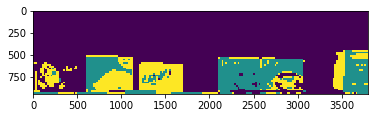

In [27]:
color_map = cluster_rackImage(kmeans, info, n_clusters, k)
plt.imshow(color_map)
plt.show

### 3.3 SURF-Based Color Map

Shape of clustered rack image: (940, 3800)


<function matplotlib.pyplot.show(*args, **kw)>

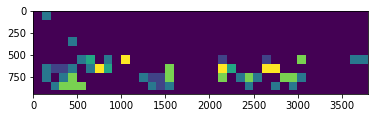

In [28]:
color_map_des = cluster_rackImage(kmeans_des, info, n_clusters_des, k_des)
plt.imshow(color_map_des)
plt.show

### 3.4 Weighted Sum Color Map

<function matplotlib.pyplot.show(*args, **kw)>

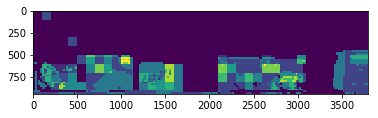

In [29]:
# Hyperparamter
alpha = 0.6

color_map_sum = alpha*(color_map_des) + (1 - alpha)*color_map
plt.imshow(color_map_sum)
plt.show

## 4. Morphological Transformations
Erosion and Closing

### 4.1  Erosion

<function matplotlib.pyplot.show(*args, **kw)>

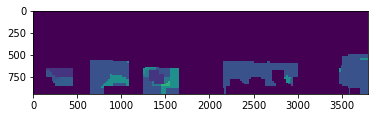

In [30]:
kernel = np.ones((100,100), np.uint8) 
erosion = cv2.erode(color_map_sum, kernel, iterations=1)
plt.imshow(erosion)
plt.show

### 4.2 Opening

<function matplotlib.pyplot.show(*args, **kw)>

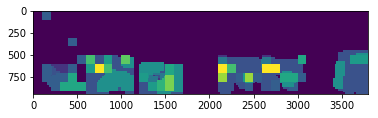

In [31]:
kernel = np.ones((100,100), np.uint8) 
opening = cv2.morphologyEx(color_map_sum, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)
plt.show

## 5. Object Expectancy Graphs

### 5.1 Necessary Functions

In [32]:
def momentum(y):
    
    #Hyperparameter
    beta = 0.99
    
    weighted_y = [y[0], ]
    for i in range(1, np.array(y).shape[0]):
        temp_y = beta*weighted_y[i-1] + (1 - beta)*y[i]
        weighted_y.append(temp_y)
        
    weighted_y = np.asarray(weighted_y)    
    
    return weighted_y

def objectExpectancy_rackImage_1(color_map, info):
        
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            if color_map[j, i] != 0: 
                sum += 1
        
        y_cluster.append(sum)

    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)
    
    return y_cluster

def weightedObjectExpectancy_rackImage_1(color_map, info):
    
    h = info[2]
    
    # Hyperparameter
    regions = 3
    
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            
            if color_map[j, i] != 0: 
                if j < 1*h/3:
                    sum += 1
                elif j < 2*h/3:
                    sum += 4
                else: 
                    sum += 9
                    
        y_cluster.append(sum)
    
    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)

    return y_cluster

def objectExpectancy_rackImage_2(color_map, info):
        
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            if color_map[j, i] != 0: 
                sum += color_map[j, i]
        
        y_cluster.append(sum)

    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)
    
    return y_cluster

def weightedObjectExpectancy_rackImage_2(color_map, info):
    
    h = info[2]
    
    # Hyperparameter
    regions = 3
    
    y_cluster = []    
    for i in range(color_map.shape[1]):
        
        sum = 0
        for j in range(color_map.shape[0]):
            
            if color_map[j, i] != 0: 
                if j < 1*h/3:
                    sum += 1*color_map[j, i]
                elif j < 2*h/3:
                    sum += 4*color_map[j, i]
                else: 
                    sum += 9*color_map[j, i]
                    
        y_cluster.append(sum)
    
    y_cluster = momentum(y_cluster)
    y_cluster = y_cluster/np.amax(y_cluster)

    return y_cluster

### 5.2 Without Morphological Transformations

#### 5.2.1 Weighted

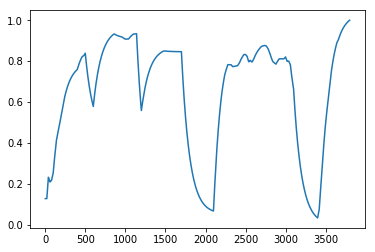

In [33]:
plt.plot(weightedObjectExpectancy_rackImage_1(color_map_sum, info))
plt.show()

#### 5.2.2 Not Weighted

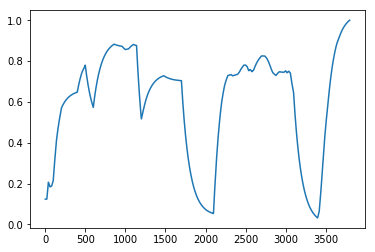

In [34]:
plt.plot(objectExpectancy_rackImage_1(color_map_sum, info))
plt.show()

### 5.3 With Erosion

#### 5.3.1 Weighted

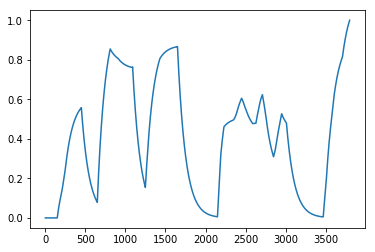

In [35]:
plt.plot(weightedObjectExpectancy_rackImage_1(erosion, info))
plt.show()

#### 5.3.2 Not Weighted

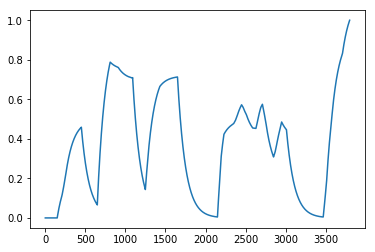

In [36]:
plt.plot(objectExpectancy_rackImage_1(erosion, info))
plt.show()

### 5.4 With Closing

#### 5.4.1 Weighted

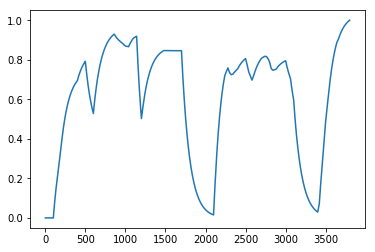

In [37]:
plt.plot(weightedObjectExpectancy_rackImage_1(opening, info))
plt.show()

#### 5.4.2 Not Weighted

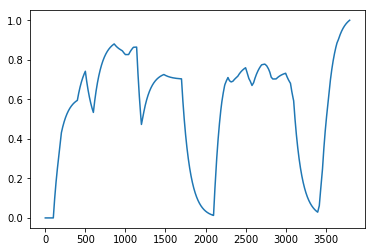

In [38]:
plt.plot(objectExpectancy_rackImage_1(opening, info))
plt.show()